In [57]:
pip install mlxtend

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from mlxtend.frequent_patterns import apriori, association_rules

In [59]:
file_path = r'C:\Users\lenovo\Desktop\online_retail_II.csv'
df = pd.read_csv(file_path)


In [60]:
#Data PreProcessing

In [61]:
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [62]:
df.shape


(1067371, 8)

In [63]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [64]:
df.isnull().sum()


Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [65]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Quantity,1067371.0,9.938898,172.705794,-80995.00,1.00,3.0,10.00,80995.0
Price,1067371.0,4.649388,123.553059,-53594.36,1.25,2.1,4.15,38970.0
Customer ID,824364.0,15324.638504,1697.464450,12346.00,13975.00,15255.0,16797.00,18287.0


In [66]:
#Exploratory Data Analysis (EDA)

In [67]:
#regulating
df.columns = [col.replace(" ", "_").upper() for col in df.columns]
df.dropna(inplace=True)


In [68]:
#Handling Outliers
df.describe().T


,count,mean,std,min,25%,50%,75%,max
QUANTITY,824364.0,12.414574,188.976099,-80995.0,2.00,5.00,12.00,80995.0
PRICE,824364.0,3.676800,70.241388,0.0,1.25,1.95,3.75,38970.0
CUSTOMER_ID,824364.0,15324.638504,1697.464450,12346.0,13975.00,15255.00,16797.00,18287.0


In [69]:
qtt = df.loc[df["QUANTITY"]<0,"QUANTITY"].count()
inv = df["INVOICE"].str.contains("C",na=False).sum()


In [70]:
df.drop(df[df["INVOICE"].str.contains("C")].index,inplace=True)


In [71]:
qtt = df.loc[df["QUANTITY"]<0,"QUANTITY"].count()
inv = df["INVOICE"].str.contains("C",na=False).sum()
print(f"The number of negative QUANTITY values: {qtt}\nThe number of INVOICES containing 'C' : {inv}")


The number of negative QUANTITY values: 0
The number of INVOICES containing 'C' : 0


In [72]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
QUANTITY,805620.0,13.307665,144.306739,1.0,2.00,5.00,12.00,80995.0
PRICE,805620.0,3.206279,29.197901,0.0,1.25,1.95,3.75,10953.5
CUSTOMER_ID,805620.0,15331.856250,1696.768395,12346.0,13982.00,15271.00,16805.00,18287.0


In [73]:
def handling_outlier(data,variable):
    quartile1 = data[variable].quantile(0.01) # Range (%1-%99)
    quartile3 = data[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    data.loc[data[variable] < low_limit, variable] = low_limit
    data.loc[data[variable] > up_limit, variable] = up_limit


In [74]:
handling_outlier(df,"QUANTITY")
handling_outlier(df,"PRICE")



In [75]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
QUANTITY,805620.0,11.842778,26.835632,1.0,2.00,5.00,12.00,318.50
PRICE,805620.0,2.949878,3.238458,0.0,1.25,1.95,3.75,36.94
CUSTOMER_ID,805620.0,15331.856250,1696.768395,12346.0,13982.00,15271.00,16805.00,18287.00


In [76]:
# Selecting some countries from the data set
list_cntry = ["Greece","Singapore","Netherlands","Switzerland","Cyprus","France","Korea","Canada"]
for number,country in enumerate(list_cntry):
    list_cntry[number] = df[df['COUNTRY'] == country]


In [77]:
del df

In [78]:
df = pd.concat(list_cntry,axis=0)
df = df.sort_index()

In [79]:
df = df.reset_index(drop=True)
df.shape


(24350, 8)

In [80]:
#Data Analysis & Visualization

In [81]:
# Top 10 best selling products

product_count = df.groupby("DESCRIPTION")["QUANTITY"].sum().nlargest(10)
product_count=product_count.reset_index()

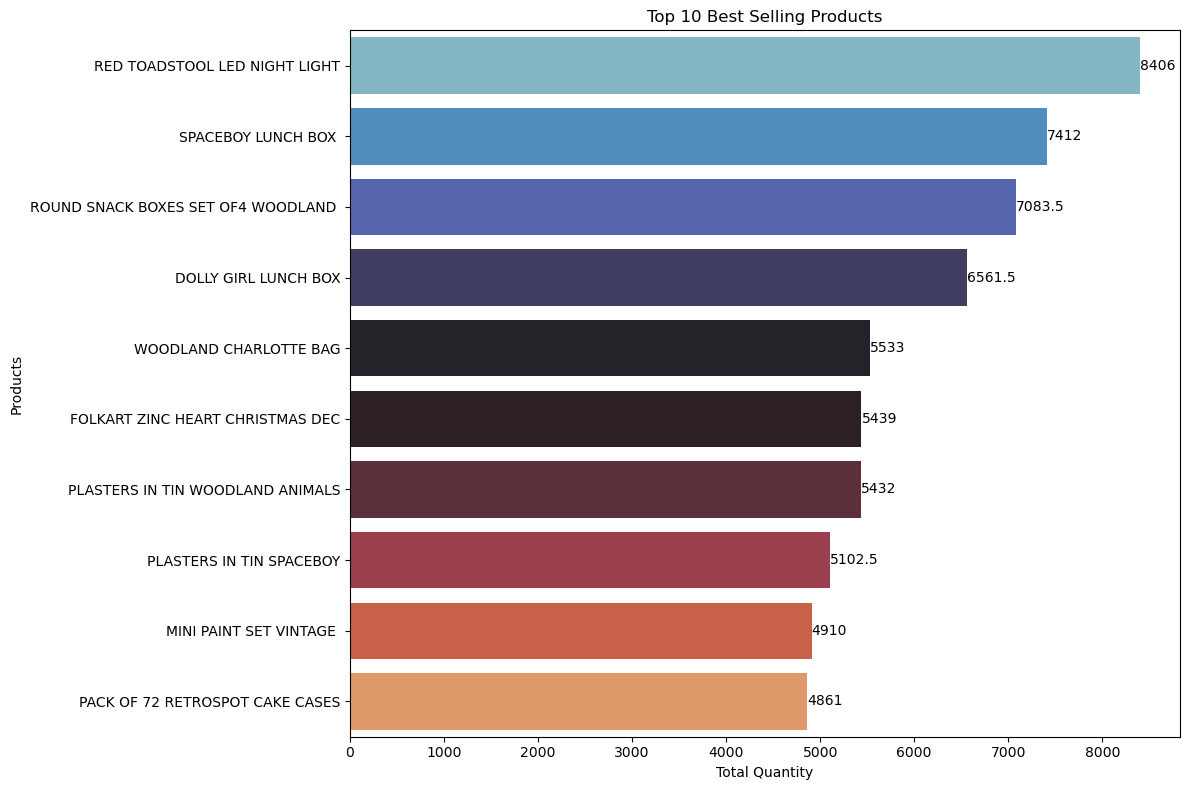

In [82]:
plt.figure(figsize=(12, 8))

ax = sns.barplot(data=product_count,y="DESCRIPTION",x="QUANTITY",palette="icefire")

for i in ax.containers:
    ax.bar_label(i,)

ax.set_title("Top 10 Best Selling Products")
plt.xlabel("Total Quantity")
plt.ylabel("Products")
plt.tight_layout()
plt.show()


In [87]:
#Preparing the ARL Data Structure

In [88]:
# Reaching the product quantities in each invoice.
df.groupby(["INVOICE","DESCRIPTION"])["QUANTITY"].sum().head(20)

# if you want you can use this code, it gives same result
# df.groupby(["INVOICE","DESCRIPTION"]).agg({"QUANTITY":"sum"}).head(20)


INVOICE  DESCRIPTION                        
489439    VINTAGE DESIGN GIFT TAGS              12.0
         ASSORTED CAKES FRIDGE MAGNETS          12.0
         ASSORTED COLOUR MINI CASES              2.0
         BAKING SET 9 PIECE RETROSPOT            9.0
         BLACK/BLUE DOTS RUFFLED UMBRELLA        3.0
         CHRISTMAS PUDDING TRINKET POT          12.0
         LUNCHBOX WITH CUTLERY RETROSPOT        12.0
         PACK 20 DOLLY PEGS                     12.0
         PARTY CONE CHRISTMAS DECORATION        24.0
         PINK DOUGHNUT TRINKET POT              12.0
         POSTAGE                                 3.0
         RED TOADSTOOL LED NIGHT LIGHT          24.0
         RED/WHITE DOTS RUFFLED UMBRELLA         3.0
         RETRO SPORT PARTY BAG + STICKER SET     8.0
         RETRO SPOT TEA SET CERAMIC 11 PC        9.0
         SET OF THREE VINTAGE GIFT WRAPS         6.0
         SET/3 RUSSIAN DOLL STACKING TINS        6.0
         WRAP BLUE RUSSIAN FOLKART              25.0
 

In [89]:
# Sorting descriptions by columns
df.groupby(["INVOICE", "DESCRIPTION"]).agg({"QUANTITY": "sum"}).unstack().iloc[0:5, 0:5]


QUANTITY                                 \
DESCRIPTION  3 STRIPEY MICE FELTCRAFT  4 PURPLE FLOCK DINNER CANDLES   
INVOICE                                                                
489439                            NaN                            NaN   
489557                            NaN                            NaN   
489883                            NaN                            NaN   
489889                            NaN                            NaN   
489890                            NaN                            NaN   

                                                                              \
DESCRIPTION  50'S CHRISTMAS GIFT BAG LARGE  CHERRY BLOSSOM  DECORATIVE FLASK   
INVOICE                                                                        
489439                                 NaN                               NaN   
489557                                 NaN                               NaN   
489883                                 NaN                               NaN   
489889                                 NaN                               NaN   
489890                                 NaN                               NaN   

                                
DESCRIPTION  DOLLY GIRL BEAKER  
INVOICE                         
489439                     NaN  
489557                     NaN  
489883                     NaN  
489889                     NaN  
489890                     NaN

In [90]:
# Filling nan values with zero
df.groupby(['INVOICE', 'DESCRIPTION']).agg({"QUANTITY": "sum"}).unstack().fillna(0).iloc[0:5, 0:5]


QUANTITY                                 \
DESCRIPTION  3 STRIPEY MICE FELTCRAFT  4 PURPLE FLOCK DINNER CANDLES   
INVOICE                                                                
489439                            0.0                            0.0   
489557                            0.0                            0.0   
489883                            0.0                            0.0   
489889                            0.0                            0.0   
489890                            0.0                            0.0   

                                                                              \
DESCRIPTION  50'S CHRISTMAS GIFT BAG LARGE  CHERRY BLOSSOM  DECORATIVE FLASK   
INVOICE                                                                        
489439                                 0.0                               0.0   
489557                                 0.0                               0.0   
489883                                 0.0                               0.0   
489889                                 0.0                               0.0   
489890                                 0.0                               0.0   

                                
DESCRIPTION  DOLLY GIRL BEAKER  
INVOICE                         
489439                     0.0  
489557                     0.0  
489883                     0.0  
489889                     0.0  
489890                     0.0

In [91]:
# 0,0 is converted to 0, if there is a value then it is 1
df.groupby(['INVOICE', 'DESCRIPTION']).agg({"QUANTITY": "sum"}).unstack().fillna(0).applymap(lambda x: 1 if x > 0 else 0).iloc[0:5, 0:5]

QUANTITY                                 \
DESCRIPTION  3 STRIPEY MICE FELTCRAFT  4 PURPLE FLOCK DINNER CANDLES   
INVOICE                                                                
489439                              0                              0   
489557                              0                              0   
489883                              0                              0   
489889                              0                              0   
489890                              0                              0   

                                                                              \
DESCRIPTION  50'S CHRISTMAS GIFT BAG LARGE  CHERRY BLOSSOM  DECORATIVE FLASK   
INVOICE                                                                        
489439                                   0                                 0   
489557                                   0                                 0   
489883                                   0                                 0   
489889                                   0                                 0   
489890                                   0                                 0   

                                
DESCRIPTION  DOLLY GIRL BEAKER  
INVOICE                         
489439                       0  
489557                       0  
489883                       0  
489889                       0  
489890                       0

In [92]:
# Changing product names with stock code
df.groupby(['INVOICE', 'STOCKCODE']).agg({"QUANTITY": "sum"}).unstack().fillna(0).applymap(lambda x: 1 if x > 0 else 0).iloc[0:5, 0:5]


QUANTITY                          
STOCKCODE    10002 10120 10123C 10123G 10125
INVOICE                                     
489439           0     0      0      0     0
489557           0     0      0      0     0
489883           0     0      0      0     0
489889           0     0      0      0     0
489890           0     0      0      0     0

In [93]:
# It ready !!
df_arl = df.groupby(['INVOICE', 'STOCKCODE']).agg({"QUANTITY": "sum"}).unstack().fillna(0).applymap(lambda x: 1 if x > 0 else 0)


In [94]:
# Finding product name from stock code
def prdct_name_finder(data,stckcde):
    product_name = data[data["STOCKCODE"] == stckcde][["DESCRIPTION"]].values[0].tolist()
    print(product_name)


In [112]:
prdct_name_finder(df,"85014A")


['BLACK/BLUE DOTS RUFFLED UMBRELLA']

In [97]:
frequent_itemsets = apriori(df_arl,min_support=0.01,use_colnames=True)


In [98]:
frequent_itemsets.sort_values("support", ascending=False)


,support,itemsets
568,0.621407,"((QUANTITY, POST))"
239,0.181368,"((QUANTITY, 22326))"
132,0.180377,"((QUANTITY, 21731))"
312,0.147671,"((QUANTITY, 22554))"
28,0.147671,"((QUANTITY, 20750))"
...,...,...
3478,0.010902,"((QUANTITY, 22554), (QUANTITY, 20718), (QUANTI..."
3480,0.010902,"((QUANTITY, 22554), (QUANTITY, 20718), (QUANTI..."
3482,0.010902,"((QUANTITY, 20723), (QUANTITY, 20719), (QUANTI..."
6392,0.010902,"((QUANTITY, 22634), (QUANTITY, 22635), (QUANTI..."


In [99]:
rules = association_rules(frequent_itemsets,metric="support",min_threshold=0.01)


In [100]:
# Filtering
rules[(rules["support"]>0.05) & (rules["confidence"]>0.1) & (rules["lift"]>5)]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
346,"((QUANTITY, 85099B))","((QUANTITY, 20712))",0.108028,0.082260,0.050545,0.467890,5.687963,0.041659,1.724719,0.924009
347,"((QUANTITY, 20712))","((QUANTITY, 85099B))",0.082260,0.108028,0.050545,0.614458,5.687963,0.041659,2.313553,0.898065
700,"((QUANTITY, 20724))","((QUANTITY, 22356))",0.123885,0.079286,0.050545,0.408000,5.145900,0.040723,1.555259,0.919595
701,"((QUANTITY, 22356))","((QUANTITY, 20724))",0.079286,0.123885,0.050545,0.637500,5.145900,0.040723,2.416869,0.875050
1444,"((QUANTITY, 21086))","((QUANTITY, 21080))",0.099108,0.104063,0.063429,0.640000,6.150095,0.053116,2.488713,0.929524
1445,"((QUANTITY, 21080))","((QUANTITY, 21086))",0.104063,0.099108,0.063429,0.609524,6.150095,0.053116,2.307162,0.934665
1446,"((QUANTITY, 21080))","((QUANTITY, 21094))",0.104063,0.097126,0.067393,0.647619,6.667833,0.057286,2.562210,0.948757
1447,"((QUANTITY, 21094))","((QUANTITY, 21080))",0.097126,0.104063,0.067393,0.693878,6.667833,0.057286,2.926726,0.941467
1546,"((QUANTITY, 21086))","((QUANTITY, 21094))",0.099108,0.097126,0.079286,0.800000,8.236735,0.069660,4.514371,0.975248
1547,"((QUANTITY, 21094))","((QUANTITY, 21086))",0.097126,0.099108,0.079286,0.816327,8.236735,0.069660,4.904856,0.973106


In [101]:
# Filtering by confidence
rules[(rules["support"]>0.05) & (rules["confidence"]>0.1) & (rules["lift"]>5)].sort_values("confidence", ascending=False)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
13318,"((QUANTITY, 21086), (QUANTITY, 21080))","((QUANTITY, 21094))",0.063429,0.097126,0.059465,0.937500,9.652423,0.053304,14.445986,0.957108
13320,"((QUANTITY, 21080), (QUANTITY, 21094))","((QUANTITY, 21086))",0.067393,0.099108,0.059465,0.882353,8.902941,0.052786,7.657582,0.951824
14117,"((QUANTITY, POST), (QUANTITY, 21094))","((QUANTITY, 21086))",0.070367,0.099108,0.060456,0.859155,8.668873,0.053482,6.396333,0.951606
1547,"((QUANTITY, 21094))","((QUANTITY, 21086))",0.097126,0.099108,0.079286,0.816327,8.236735,0.069660,4.904856,0.973106
4872,"((QUANTITY, 22630))","((QUANTITY, 22629))",0.108028,0.135778,0.087215,0.807339,5.946026,0.072547,4.485724,0.932563
1546,"((QUANTITY, 21086))","((QUANTITY, 21094))",0.099108,0.097126,0.079286,0.800000,8.236735,0.069660,4.514371,0.975248
14118,"((QUANTITY, 21086), (QUANTITY, POST))","((QUANTITY, 21094))",0.077304,0.097126,0.060456,0.782051,8.051936,0.052948,4.142599,0.949182
22704,"((QUANTITY, POST), (QUANTITY, 22551))","((QUANTITY, 22554))",0.076313,0.147671,0.058474,0.766234,5.188791,0.047204,3.646074,0.873973
13319,"((QUANTITY, 21086), (QUANTITY, 21094))","((QUANTITY, 21080))",0.079286,0.104063,0.059465,0.750000,7.207143,0.051214,3.583746,0.935414
4698,"((QUANTITY, 22555))","((QUANTITY, 22556))",0.079286,0.146680,0.058474,0.737500,5.027956,0.046844,3.250743,0.870099


In [102]:
#Application

In [103]:
def prdct_name_finder(data,stckcde):
    product_name = data[data["STOCKCODE"] == stckcde][["DESCRIPTION"]].values[0].tolist()
    return product_name


In [119]:
def arl_recommender(rules_df, product_id, rec_count):
    
    sorted_rules = rules_df.sort_values("lift", ascending=False)
    recommendation_list = []
    recommendation_list_name = []
    
    for i, product in enumerate(sorted_rules["antecedents"]):
        for j in list(product):
            if j[1] == product_id:
                for k in list(sorted_rules.iloc[i]["consequents"]):
                    if k[1] not in recommendation_list:
                        recommendation_list.append(k[1])
    added_product = prdct_name_finder(df,product_id)
    print(f"Added to Cart:           {added_product[0]}\n\n")
    print(f"Members Who Bought This Also Bought:\n\n")
    for i in range(0,rec_count):
        recommendation_list_name.append(prdct_name_finder(df,recommendation_list[i]))
        print(f"                         {recommendation_list_name[i][0]}\n")

        


In [120]:
arl_recommender(rules, "85123A", 3)


Added to Cart:           WHITE HANGING HEART T-LIGHT HOLDER


Members Who Bought This Also Bought:


                         RED HANGING HEART T-LIGHT HOLDER

                         ZINC METAL HEART DECORATION

                         FOLKART ZINC HEART CHRISTMAS DEC

